# Questão 1

Considere o conjunto de dados disponível em artificial1d.csv organizado em duas colunas, x e y. Seja um modelo de regressão linear para ˆy = f(x).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from scipy.stats import shapiro

In [2]:
artificial1d = np.loadtxt("artificial1d.csv", delimiter=',')

In [3]:
artificial1d.shape

(30, 2)

In [4]:
# Fiz uma classe para a regressão linear para essa primeira questão - todos os itens vão usar ela
class RegressaoLinear():
    """
     Implementa um modelo de Regressão Linear.
    """
    def __init__(self, y, X):
        """
        Inicializa a Regressão Linear com os dados de entrada e saída.
        """
        self.N = X.shape[0] # Número de observações
        self.VarN = X.shape[1] # Número de variáveis
        self.X = X
        self.y = y
        self.y_hat = None
        self.residuos = None # erro
        self.mse = None
        self.w = None
        self.historico_custo = [] # histórico do custo (MSE)
        self.historico_w = []

    def fit_gd(self, alpha=0.01, max_epocas=500, tolerancia=1e-8):
        """
        Fit usando o algoritmo Gradiente Descendente.
        """
        start_time = time() # só para calcular o tempo que demorou para executar
        epoca = 0
        self.w = np.zeros((self.VarN,1)) # inicializa os pesos com zero | Reseta o treinamento
        self.historico_custo = []
        self.historico_w = []
        
        while epoca < max_epocas:
            epoca += 1
            self.y_hat = self.X @ self.w
            self.residuos = self.y - self.y_hat # erro
            self.mse = 1 / (2 * self.N) * np.sum(self.residuos**2)
            self.w = self.w + alpha * (1 / self.N) * (self.X.T @ self.residuos)

            self.historico_custo.append((epoca, self.mse))
            self.historico_w.append((epoca, self.w))

            if epoca > 1 and abs(self.historico_custo[-2][1] - self.mse) < tolerancia: # Verifica se a variação do MSE é baixa
                motivo = "O erro não variou significativamente (convergência atingida)"
                break

        if epoca >= max_epocas:
            motivo = "Número máximo de épocas atingido"

        self._print_resultados(motivo, epoca, start_time, tipo="gd")

    def fit_sgd(self, alpha=0.01, max_epocas=500, tolerancia=1e-8):
        """
        Fit usando o algoritmo Gradiente Descendente Estocástico.
        """
        start_time = time()  # só para calcular o tempo que demorou para executar
        epoca = 0
        flag_convergencia = True
        self.w = np.zeros((self.VarN,1)) # inicializa os pesos com zero | Reseta o treinamento
        self.historico_custo = []
        self.historico_w = []
        
        while epoca < max_epocas and flag_convergencia: # Uma flag para verificar se a variação do MSE é baixa
            indices = np.random.permutation(self.N)
            X_permuted = self.X[indices]
            y_permuted = self.y[indices]
            for i in range(self.N):
                epoca += 1
                xi = X_permuted[i].reshape(1, -1) 
                yi = y_permuted[i]
                y_hat_t_m1 = xi @ self.w
                e_t_m1 = yi - y_hat_t_m1
                self.w = self.w + alpha * e_t_m1 * xi.T

                # Eu calculei e salvei o erro a cada observação
                self.y_hat = self.X @ self.w
                self.residuos = self.y - self.y_hat
                self.mse = 1 / (2 * self.N) * np.sum(self.residuos**2)
                self.historico_custo.append((epoca, self.mse))
                self.historico_w.append((epoca, self.w))

                if epoca > 1 and abs(self.historico_custo[-2][1] - self.mse) < tolerancia:
                    motivo = "O erro não variou significativamente (convergência atingida)"
                    flag_convergencia = False
                    break
      
                if epoca == max_epocas:
                    motivo = "Número máximo de épocas atingido"
                    break

        self._print_resultados(motivo, epoca, start_time, tipo="sgd")

    def fit_analitica(self):
        """
        Fit usando o OLS.
        """
        self.historico_custo = [] # Apagar o histórico caso tenha feito um sgd ou gd antes com o mesmo objeto.
        self.historico_w = [] # Apagar o histórico caso tenha feito um sgd ou gd antes com o mesmo objeto.
        
        self.w = np.linalg.solve(self.X.T @ self.X, self.X.T @ self.y)
        self.y_hat = self.X @ self.w
        self.residuos = self.y - self.y_hat
        self.mse = 1 / (2 * self.N) * np.sum(self.residuos**2)
        
        motivo = "Solução analítica"
        
        self._print_resultados(motivo, epoca = 0, start_time = 0, tipo="analitica")

    def _print_resultados(self, motivo, epoca, start_time, tipo):
        """
        Faz um print dos resultados - depois do fit
        """
        print(f"\nTreinamento {tipo} finalizado - Motivo: {motivo}")
        print(
            "Equação final: "
            + "y = "
            + " + ".join([f"{x:.3f} * x{n}" for n, x in enumerate(self.w.reshape(1,-1)[0])]).replace(
                " * x0", ""
            )
        )
        print(f"Épocas realizadas: {epoca}") if tipo != "analitica" else ""
        print(f"Erro final (MSE): {self.mse:.6f}\n")
        end_time = time()
        execution_time = end_time - start_time 
        print(f"Tempo de execução: {execution_time:.4f} segundos") if tipo != "analitica" else ""

    def plot_custo(self):
        """
        Plota o custo - histórico do MSE
        """
        if not self.historico_custo:
            print("Você usou o treinamento analítico")
        else:
            ep, er = zip(*self.historico_custo)
            plt.figure(figsize=(10, 5))
            plt.plot(ep, er, label="MSE")
            plt.xlabel("Épocas")
            plt.ylabel("MSE")
            plt.title("Custo")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()
    
    
    def plot_residuos(self):
        """
        Plota o resíduos (erro), faz um teste estatístico de normalidade também.
        """
        
        statistic, p_value = shapiro(self.residuos)

        fig, ax = plt.subplots(figsize=(8, 5))

        sns.histplot(self.residuos, ax=ax, kde=True)

        result_text = f"Shapiro-Wilk Test\nStatistic={statistic:.4f}\np-value={p_value:.4f}"
        plt.figtext(0.75,0.75, result_text, fontsize=12, color="black", ha="center")

        ax.set_title("Resíduos")
        ax.grid(False)

        plt.show()
            
    def plot_regressao_linear_1X(self):
        """
        Plota a regressão linear, somente quando X tem uma variável e o intercepto
        """
        if self.VarN > 2:
            print("X tem mais de uma variável")
        else:
            x_plot = np.linspace(self.X.min(), self.X.max(), 100)
            y_plot = self.w[0] + self.w[1] * x_plot

            fig, ax = plt.subplots(figsize=(8, 5))

            ax.scatter(x=self.X[:,1], y=self.y, label="Dados Reais", color="red")

            ax.plot(x_plot, y_plot, label="Regressão Linear", color="blue")

            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_title("Gráfico da Regressão Linear")
            ax.grid(True)
            ax.legend()

            plt.show()

## a) Apresente os parâmetros do modelo e o MSE (erro quadrático médio) obtidos pelo algoritmo OLS (mínimos quadrados ordinários). Plote a reta resultante sobre os dados.

In [5]:
X = artificial1d[:,0]
y = artificial1d[:,1]

In [6]:
X

array([-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
       -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
       -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
        0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
        0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
        0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ])

In [7]:
ones_vetor = np.ones(X.shape)

In [8]:
X = X.reshape(-1,1)
ones_vetor = ones_vetor.reshape(-1,1)

In [9]:
X = np.concat([ones_vetor, X], axis=1)

In [10]:
X[:5,:]

array([[ 1.        , -1.        ],
       [ 1.        , -0.93103448],
       [ 1.        , -0.86206897],
       [ 1.        , -0.79310345],
       [ 1.        , -0.72413793]])

In [11]:
y = y.reshape(-1,1)

In [12]:
y[:5,:]

array([[-2.08201726],
       [-1.32698023],
       [-1.10559772],
       [-0.87394576],
       [-0.28502695]])

In [13]:
regressao_linear = RegressaoLinear(X=X,y=y) # Observação essa classe está definida nas células acima

In [14]:
regressao_linear.fit_analitica()


Treinamento analitica finalizado - Motivo: Solução analítica
Equação final: y = 0.068 + 1.575 * x1
Erro final (MSE): 0.106700



In [15]:
regressao_linear.w

array([[0.06761792],
       [1.57486517]])

In [16]:
regressao_linear.mse # Observação usei o MSE dos slides que usa 1/2N

np.float64(0.10670045066468496)

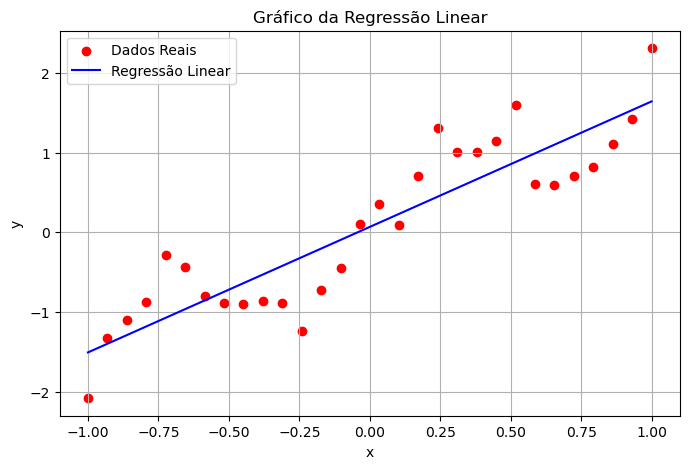

In [17]:
regressao_linear.plot_regressao_linear_1X()

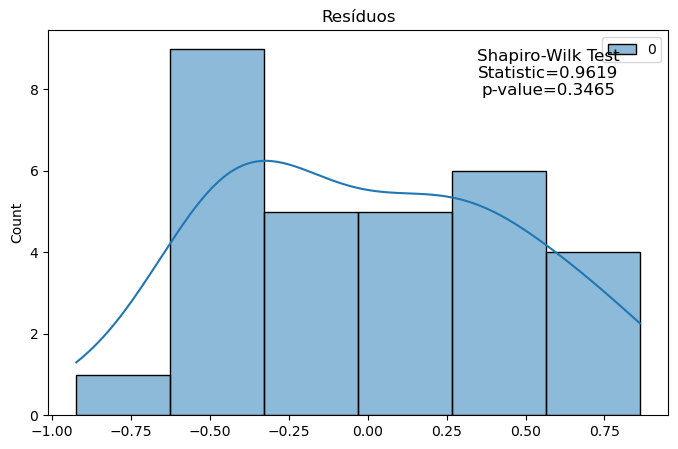

In [18]:
regressao_linear.plot_residuos()

## b) Apresente os parâmetros do modelo, o MSE e a curva de aprendizagem obtidos pelo algoritmo GD (gradiente descendente). Plote a reta resultante sobre os dados.

In [19]:
regressao_linear = RegressaoLinear(X=X,y=y) # Observação: essa classe está definida nas primeiras células

In [20]:
regressao_linear.fit_gd(max_epocas=500, alpha=0.02)


Treinamento gd finalizado - Motivo: Número máximo de épocas atingido
Equação final: y = 0.068 + 1.531 * x1
Épocas realizadas: 500
Erro final (MSE): 0.107052

Tempo de execução: 0.0080 segundos


In [21]:
regressao_linear.w

array([[0.06761515],
       [1.53078767]])

In [22]:
regressao_linear.mse # Observação usei o MSE dos slides que usa 1/2N

np.float64(0.1070515729584837)

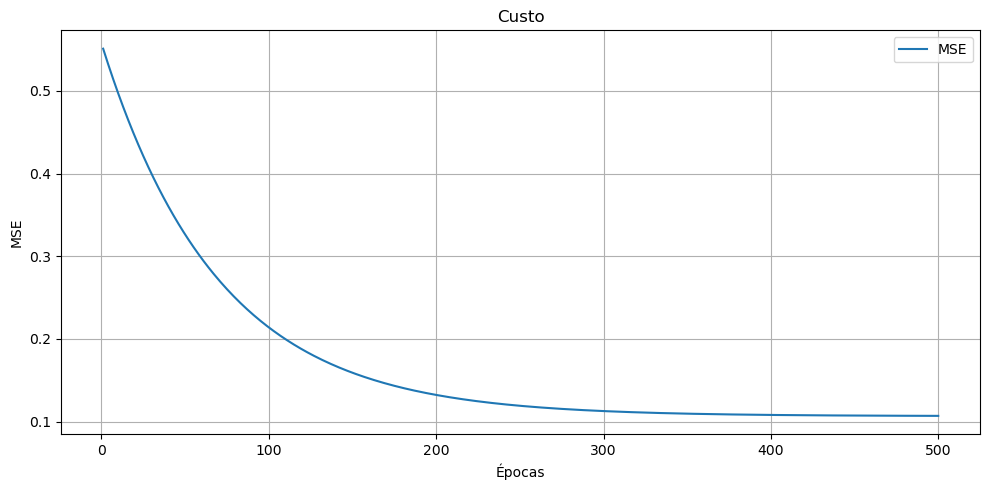

In [23]:
regressao_linear.plot_custo()

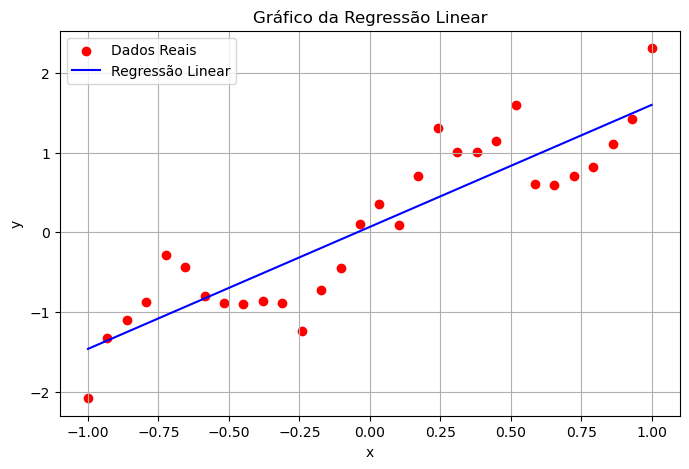

In [24]:
regressao_linear.plot_regressao_linear_1X()

## c) Apresente os parâmetros do modelo, o MSE e a curva de aprendizagem obtidos pelo algoritmo SGD (gradiente descendente estocástico). Plote a reta resultante sobre os dados.

In [25]:
regressao_linear = RegressaoLinear(X=X,y=y) # Observação: essa classe está definida nas primeiras células

In [26]:
regressao_linear.fit_sgd(max_epocas=1000, alpha=0.01)


Treinamento sgd finalizado - Motivo: Número máximo de épocas atingido
Equação final: y = 0.074 + 1.546 * x1
Épocas realizadas: 1000
Erro final (MSE): 0.106869

Tempo de execução: 0.0150 segundos


In [27]:
regressao_linear.w

array([[0.07362531],
       [1.54578191]])

In [28]:
regressao_linear.mse # Observação usei o MSE dos slides que usa 1/2N

np.float64(0.10686918991319318)

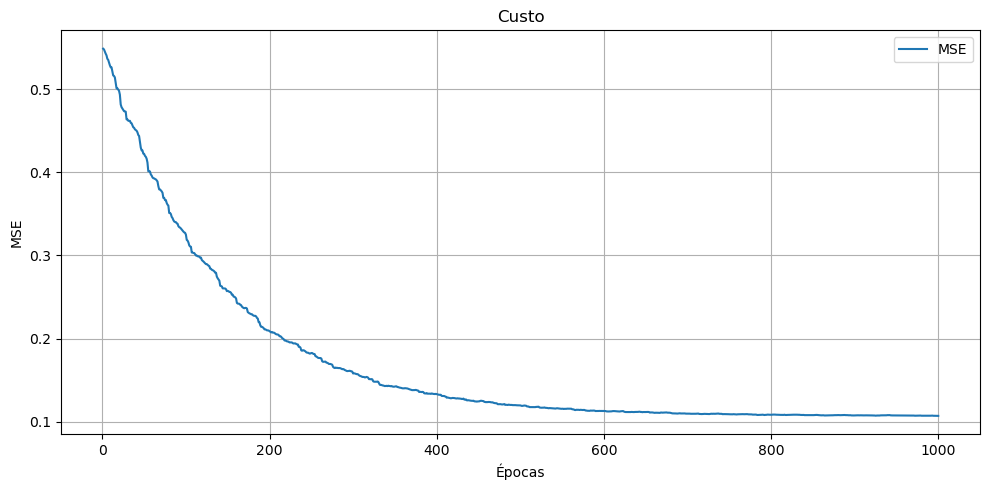

In [29]:
regressao_linear.plot_custo()

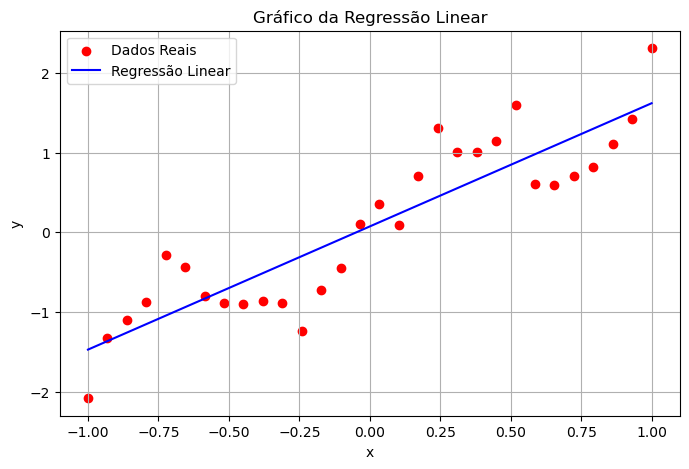

In [30]:
regressao_linear.plot_regressao_linear_1X()

# Questão 2
Considere o conjunto de dados disponível em california.csv, organizado em 9
colunas, sendo as 8 primeiras colunas os atributos e a última coluna a saída.
Os 8 atributos são usados na predição da mediana de preços de casas em distritos
da Califórnia na década de 1990. Maiores detalhes sobre os dados podem
ser conferidos em https://scikit-learn.org/stable/datasets/real_
world.html#california-housing-dataset.

In [31]:
california = np.loadtxt("california.csv", delimiter=',')

In [32]:
california[:5,:]

array([[ 4.16850000e+00,  2.00000000e+01,  6.70063694e+00,
         1.17834395e+00,  7.45000000e+02,  2.37261146e+00,
         3.88000000e+01, -1.21150000e+02,  2.17500000e+00],
       [ 2.81940000e+00,  2.40000000e+01,  4.76250000e+00,
         1.02083333e+00,  6.08000000e+02,  2.53333333e+00,
         3.67500000e+01, -1.19850000e+02,  8.11000000e-01],
       [ 2.42500000e+00,  4.60000000e+01,  4.92771084e+00,
         1.01807229e+00,  7.72000000e+02,  2.32530120e+00,
         3.63300000e+01, -1.19310000e+02,  8.49000000e-01],
       [ 3.12050000e+00,  1.60000000e+01,  3.72847682e+00,
         1.10154525e+00,  1.26000000e+03,  2.78145695e+00,
         3.38700000e+01, -1.17990000e+02,  1.74000000e+00],
       [ 4.38890000e+00,  4.10000000e+01,  5.74100719e+00,
         1.19904077e+00,  8.37000000e+02,  2.00719424e+00,
         3.41500000e+01, -1.18400000e+02,  3.80400000e+00]])

In [33]:
california.shape

(1000, 9)

## a) Aleatoriamente, divida o conjunto de dados em treino (80%) e teste (20%).

In [34]:
size_data = california.shape[0]

In [35]:
tamanho_treino = int(0.8 * size_data)

In [36]:
tamanho_treino

800

In [37]:
random_seed = np.random.default_rng(seed=1) 
id_random = random_seed.permutation(size_data)

In [38]:
id_treino = id_random[:tamanho_treino]
id_teste = id_random[tamanho_treino:]

In [39]:
treino = california[id_treino,:]

In [40]:
teste = california[id_teste,:]

## b) Treine 13 modelos de regressão polinomial, com ordens de 1 a 13. Você pode usar o algoritmo OLS.

In [41]:
def ols(X, y):
    """
    Fit um OLS - fiz com que o intercepto fosse inserido nesta função
    """
    ones_vetor = np.ones(X.shape[0])
    ones_vetor = ones_vetor.reshape(-1, 1)
    X = np.concatenate([ones_vetor, X], axis=1)
    w = np.linalg.solve(X.T @ X, X.T @ y)
    return w


def predict(X, w):
    """
    Prever os valores a partir de X e w - fiz com que o intercepto fosse inserido nesta função
    """
    ones_vetor = np.ones(X.shape[0])
    ones_vetor = ones_vetor.reshape(-1, 1)
    X = np.concatenate([ones_vetor, X], axis=1)
    y_hat = X @ w
    return y_hat


def rmse(y, y_hat):
    """
    Calcula o RMSE
    """
    return np.sqrt((((y - y_hat) ** 2) / y.shape[0]).sum())

In [42]:
class StandardScaler:
    """
    Classe para padronizar usando z-score
    """

    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, ddof=1, axis=0)

    def fit_transform(self, X):
        self.fit(X)
        return (X - self.mean) / self.std

    def transform(self, X):
        return (X - self.mean) / self.std

    def inverse(self,X):
        return X * self.std + self.mean

In [43]:
class MinMax:
    """
    Classe para padronizar usando min-max
    """

    def __init__(self):
        self.max = None
        self.min = None

    def fit(self, X):
        self.min_val = np.min(X, axis=0)
        self.max_val = np.max(X, axis=0)

    def fit_transform(self, X):
        self.fit(X)
        return (X - self.min_val) / (self.max_val - self.min_val)

    def transform(self, X):
        return (X - self.min_val) / (self.max_val - self.min_val)

    def inverse(self, X):
        return X * (self.max_val - self.min_val) + self.min_val

In [44]:
X_treino = treino[:,0:8]
y_treino = treino[:,8].reshape(-1,1)

In [45]:
X_teste = teste[:,0:8]
y_teste = teste[:,8].reshape(-1,1)

In [46]:
X_min_max = MinMax()

In [47]:
X_treino_max_min = X_min_max.fit_transform(X_treino)

In [48]:
# Criei uma única variável X com todas as potências (X, X², X³, ...).
# O valor de 'Cuts' define até qual potência considerar:
# - 8  -> apenas o X sem potências
# - 16 -> inclui X e X²
# - 24 -> inclui X, X² e X³
# ...e assim por diante.

X_treino_max_min_order = X_treino_max_min.copy()
cuts = [X_treino_max_min_order.shape[1]]
for pot in range(2,14):
    X_treino_max_min_order_pot = X_treino_max_min ** pot
    X_treino_max_min_order = np.concat([X_treino_max_min_order, X_treino_max_min_order_pot], axis=1)
    cuts.append(X_treino_max_min_order.shape[1])

In [49]:
cuts

[8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104]

In [50]:
X_min_max_order = MinMax()

In [51]:
X_treino_max_min_order = X_min_max_order.fit_transform(X_treino_max_min_order)

In [52]:
X_treino_max_min_order.shape

(800, 104)

In [53]:
y_standard = StandardScaler()

In [54]:
y_treino_standard = y_standard.fit_transform(y_treino)

In [55]:
# Vou treinar os modelos usando o valor de 'Cuts' como base.
# Ele define até onde cada modelo deve usar as variáveis (potências de X).
w_list = []
max_min_order = []
for cut in cuts:
    X_treino_max_min_order_fit = X_treino_max_min_order[:,:cut] # modelo vai usar as variáveis até o valor de 'cut'
    w = ols(X_treino_max_min_order_fit,y_treino_standard) # lembrando que a função ols insere o intercepto
    w_list.append(w)

In [56]:
w_list # pesos dos modelos

[array([[ 1.76152496],
        [ 5.24845546],
        [ 0.5834987 ],
        [-2.16942708],
        [ 2.99697372],
        [ 0.21411871],
        [-2.11412582],
        [-3.4706265 ],
        [-3.26461874]]),
 array([[ 1.54725898],
        [ 7.18082258],
        [ 0.82027962],
        [-4.91212889],
        [ 6.44115215],
        [ 0.22890106],
        [-4.59584345],
        [-4.5670434 ],
        [-2.12134638],
        [-2.50755018],
        [-0.12427101],
        [ 7.46628564],
        [-9.10593268],
        [ 0.26623459],
        [ 4.63299932],
        [ 1.46425356],
        [-1.1904806 ]]),
 array([[  1.51593163],
        [  3.81114938],
        [  2.02167455],
        [-10.68170408],
        [ 11.51370758],
        [  0.93019129],
        [ -6.99513282],
        [ -3.2048381 ],
        [  0.19292029],
        [  8.15172686],
        [ -2.56163337],
        [ 36.74384526],
        [-36.60158114],
        [ -2.8542841 ],
        [ 11.80493769],
        [ -2.51062825],
        [ -6.6

## c) Reporte o RMSE (raiz quadrada do erro quadrático médio) no treinamento e no teste para cada modelo. Faça um gráfico para o treino e um gráfico para o teste.

In [57]:
y_teste_standard = y_standard.transform(y_teste) # padroniza y do teste usando as métricas do treino

In [58]:
# mesma coisa de antes de criar um X com todas as potências, mas agora para o teste
X_teste_max_min = X_min_max.transform(X_teste) # usa as métricas do treino para padronizar o teste

X_teste_max_min_order = X_teste_max_min.copy()
for pot in range(2,14):
    X_teste_max_min_order_pot = X_teste_max_min ** pot # X^pot
    X_teste_max_min_order = np.concat([X_teste_max_min_order, X_teste_max_min_order_pot], axis=1) # junta os dados

X_teste_max_min_order = X_min_max_order.transform(X_teste_max_min_order) # usa as métricas do treino para padronizar o teste
X_teste_max_min_order.shape

(200, 104)

In [59]:
rmse_list = []
for i, w in enumerate(w_list): # w_list são os modelos treinados
    X_treino_max_min_order_fit = X_treino_max_min_order[:, : cuts[i]] # pegar as variáveis do modelo correspondente
    y_treino_hat = predict(X_treino_max_min_order_fit, w) # prever os valores | lembrando que a função predict insere o intercepto
    y_treino_hat = y_standard.inverse(y_treino_hat) # despadroniza
    rmse_treino = rmse(y_treino, y_treino_hat) # calcula o rmse
    
    X_teste_max_min_order_fit = X_teste_max_min_order[:, : cuts[i]] # pegar as variáveis do modelo correspondente
    y_teste_hat = predict(X_teste_max_min_order_fit, w) # prever os valores | lembrando que a função predict insere o intercepto
    y_teste_hat = y_standard.inverse(y_teste_hat) # despadroniza
    rmse_teste = rmse(y_teste, y_teste_hat) # calcula o rmse
    
    rmse_list.append((rmse_treino,rmse_teste)) # salvar os resultados

In [60]:
rmse_list # Treino e Teste

[(np.float64(0.6670271800080699), np.float64(0.6865877184653485)),
 (np.float64(0.6404857414503368), np.float64(0.6912800437727695)),
 (np.float64(0.6210671277805947), np.float64(0.8590893217544183)),
 (np.float64(0.6097914030908421), np.float64(2.6322018500016706)),
 (np.float64(0.5990697995285029), np.float64(115.69222436883165)),
 (np.float64(0.5874329217620703), np.float64(1171.3805658020863)),
 (np.float64(0.5807058405251552), np.float64(7217.075565503116)),
 (np.float64(0.5796993470398135), np.float64(810.715352928197)),
 (np.float64(0.5783916194524034), np.float64(285213.627519398)),
 (np.float64(0.5734121381238818), np.float64(5426404.851293428)),
 (np.float64(0.5700096463103226), np.float64(54373672.482871935)),
 (np.float64(0.5875947905756647), np.float64(308218868.23572147)),
 (np.float64(0.5768031413359511), np.float64(938854683.7795749))]

In [61]:
rmse_treino, rmse_teste = zip(*rmse_list)

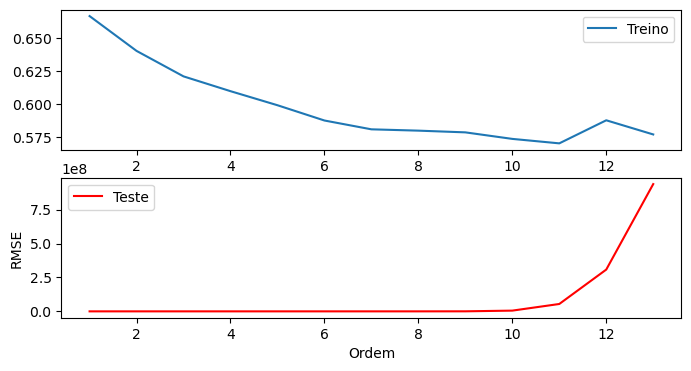

In [62]:
order = list(range(1, 14))
figure, ax = plt.subplots(2,1,figsize=(8, 4))
sns.lineplot(x=order, y=rmse_treino, ax=ax[0], label="Treino")
sns.lineplot(x=order, y=rmse_teste, ax=ax[1], label="Teste", color='red')
plt.xlabel("Ordem")
plt.ylabel("RMSE")
plt.show()

## d) Repita os 2 itens anteriores incluindo um termo de regularização L2 (por exemplo, com fator λ = 0.01).

In [63]:
def ols_l2(X, y, lmbda = 0.01):
    """
    Fit com OLS com regularização L2
    """
    ones_vetor = np.ones(X.shape[0])
    ones_vetor = ones_vetor.reshape(-1, 1)
    X = np.concatenate([ones_vetor, X], axis=1)
    eye = np.eye(X.shape[1])
    eye[0, 0] = 0
    w = np.linalg.solve(X.T @ X + lmbda * eye, X.T @ y)
    return w

In [64]:
w_list = []
max_min_order = []
for cut in cuts:
    X_treino_max_min_order_fit = X_treino_max_min_order[:,:cut]
    w = ols_l2(X_treino_max_min_order_fit,y_treino_standard) # lembrando que a função ols_l2 insere o intercepto
    w_list.append(w)

In [65]:
rmse_list = []
for i, w in enumerate(w_list):
    X_treino_max_min_order_fit = X_treino_max_min_order[:, : cuts[i]]
    y_treino_hat = predict(X_treino_max_min_order_fit, w)
    y_treino_hat = y_standard.inverse(y_treino_hat)
    rmse_treino = rmse(y_treino, y_treino_hat)
    
    X_teste_max_min_order_fit = X_teste_max_min_order[:, : cuts[i]]
    y_teste_hat = predict(X_teste_max_min_order_fit, w)
    y_teste_hat = y_standard.inverse(y_teste_hat)
    rmse_teste = rmse(y_teste, y_teste_hat)
    rmse_list.append((rmse_treino,rmse_teste))

In [66]:
rmse_list

[(np.float64(0.6670338860269857), np.float64(0.6867088948819817)),
 (np.float64(0.6409614440764634), np.float64(0.6850042294182543)),
 (np.float64(0.6278690335490968), np.float64(0.7872575367447605)),
 (np.float64(0.6257186551642399), np.float64(1.1013227133288654)),
 (np.float64(0.6243336510340558), np.float64(1.59800805648337)),
 (np.float64(0.6233004119655281), np.float64(2.0972255744516946)),
 (np.float64(0.6223270115634727), np.float64(2.362348841871315)),
 (np.float64(0.6212271228050865), np.float64(2.1177984281291815)),
 (np.float64(0.6200335063183724), np.float64(1.0480791596356693)),
 (np.float64(0.6189213043583466), np.float64(2.084252435795079)),
 (np.float64(0.6180170174471794), np.float64(7.358905537050083)),
 (np.float64(0.6173458750150674), np.float64(16.836400476265275)),
 (np.float64(0.61687821793015), np.float64(33.00420692083656))]

In [67]:
rmse_treino, rmse_teste = zip(*rmse_list)

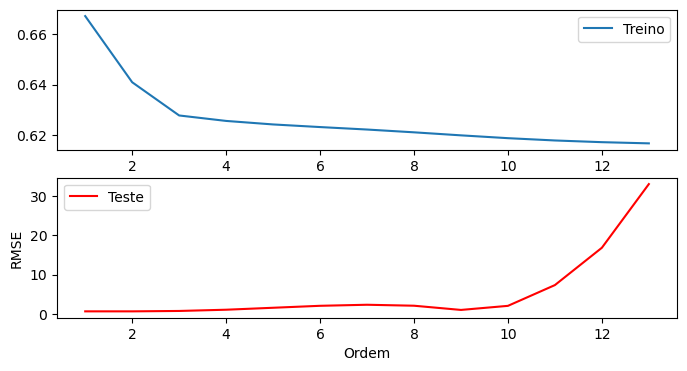

In [68]:
order = list(range(1, 14))
figure, ax = plt.subplots(2,1,figsize=(8, 4))
sns.lineplot(x=order, y=rmse_treino, ax=ax[0], label="Treino")
sns.lineplot(x=order, y=rmse_teste, ax=ax[1], label="Teste", color='red')
plt.xlabel("Ordem")
plt.ylabel("RMSE")
plt.show()